In [1]:
import sys, time, os
from pathlib import Path
import copy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from bmi_topography import Topography
from landlab import RasterModelGrid, imshowhs_grid, imshow_grid
from landlab.components import FlowAccumulator, PriorityFloodFlowRouter, ChannelProfiler, SpaceLargeScaleEroder
from landlab.io import read_esri_ascii, write_esri_ascii
from landlab.io.netcdf import read_netcdf
from landlab.utils import get_watershed_mask

# [SPACE large-scale](https://landlab.readthedocs.io/en/latest/reference/components/space.html#module-landlab.components.space.space_large_scale_eroder)

In [2]:
# import large DEM

topo = Topography(
    dem_type="SRTMGL1",
    api_key = '1f3ea82738663688170f0d898b59ca1d',
    south=43.972829,
    north=44.013602,
    west=-123.860848,
    east=-123.795973,
    output_format="AAIGrid",
    cache_dir="DEMData//"
    )

fname = topo.fetch()
dem = topo.load()
grid_geog, elev = read_esri_ascii(fname, name='topographic__elevation')   

In [3]:
grid = RasterModelGrid ((grid_geog.number_of_node_rows, grid_geog.number_of_node_columns), 30) # 30 meters
grid.add_field('topographic__elevation', elev, at = 'node')

num_rows, num_columns = grid.shape 
node_spacing = grid.dx

In [4]:
node_next_to_outlet = num_columns + 1
np.random.seed(seed=5000)

# get soil__depth, bedrock__elevation, topographic__elevation from previous models
_ = grid.add_zeros("soil__depth", at="node")
# grid.at_node["soil__depth"][grid.core_nodes] = 2.0
grid.at_node["soil__depth"][grid.core_nodes] = 0.5

# why do we divide by 10?
_ = grid.add_zeros("bedrock__elevation", at="node")
grid.at_node["bedrock__elevation"] += (
    grid.node_y / 10. + grid.node_x / 10. + np.random.rand(len(grid.node_y)) / 10.
)
grid.at_node["bedrock__elevation"][:] = grid.at_node["topographic__elevation"]
grid.at_node["topographic__elevation"][:] += grid.at_node["soil__depth"]

grid.set_closed_boundaries_at_grid_edges(
    bottom_is_closed=True,
    left_is_closed=True,
    right_is_closed=True,
    top_is_closed=True,
)

grid.set_watershed_boundary_condition_outlet_id(
    0, grid.at_node['topographic__elevation'], -9999.0
)

In [5]:
flood_router = PriorityFloodFlowRouter(grid, flow_metric='D8', suppress_out = True)
space = SpaceLargeScaleEroder(
    grid,
    K_sed=0.00001, # erodibility for sediment
    K_br=0.00000000001, # erodibility for bedrock
)

In [17]:
timestep = 50.0  #was 10
elapsed_time = 0.0
count = 0
run_time = 1e3  #was 1e2
sed_flux = np.zeros(int(run_time // timestep))

In [18]:
while elapsed_time < run_time:
    flood_router.run_one_step()
    _ = space.run_one_step(dt=timestep)
    sed_flux[count] = grid.at_node["sediment__flux"][node_next_to_outlet]
    elapsed_time += timestep
    count += 1

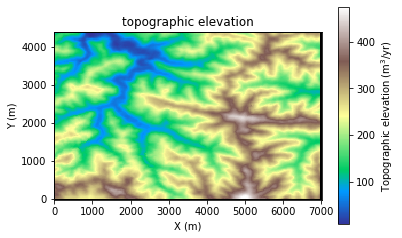

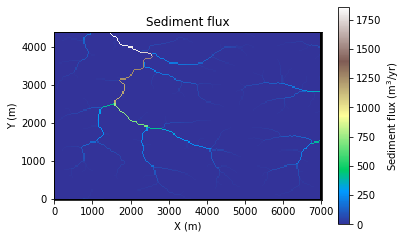

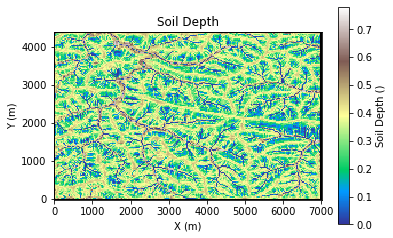

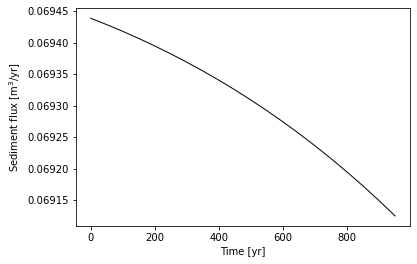

In [19]:
fig = plt.figure()
plot = plt.subplot()
_ = imshow_grid(
    grid,
    "topographic__elevation",
    plot_name="topographic elevation",
    var_name="Topographic elevation",
    var_units=r"m$^3$/yr",
    grid_units=("m", "m"),
    cmap="terrain",
)
_ = plt.figure()

_ = imshow_grid(
    grid,
    "sediment__flux",
    plot_name="Sediment flux",
    var_name="Sediment flux",
    var_units=r"m$^3$/yr",
    grid_units=("m", "m"),
    cmap="terrain",
)
fig = plt.figure()

_ = imshow_grid(
    grid,
    "soil__depth",
    plot_name="Soil Depth",
    var_name="Soil Depth",
    var_units=r"",
    grid_units=("m", "m"),
    cmap="terrain",
)
fig = plt.figure()

sedfluxplot = plt.subplot()
_ = sedfluxplot.plot(np.arange(len(sed_flux)) * timestep, sed_flux, color="k", linewidth=1.0)
_ = sedfluxplot.set_xlabel("Time [yr]")
_ = sedfluxplot.set_ylabel(r"Sediment flux [m$^3$/yr]")

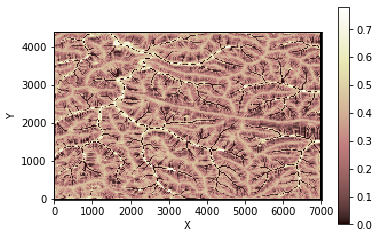

In [20]:
_ = imshow_grid(grid, "soil__depth")

In [21]:
def list_keys(grid):
    for group in grid.groups:
        for field in grid.keys(group):
            print(field)
list_keys(grid)

topographic__elevation
soil__depth
bedrock__elevation
water__unit_flux_in
flow__link_to_receiver_node
drainage_area
flood_status_code
flow__upstream_node_order
flow__receiver_node
surface_water__discharge
topographic__steepest_slope
flow__receiver_proportions
squared_length_adjacent
sediment__influx
sediment__outflux
sediment__flux
depression_free_elevation


In [22]:
# topographic__elevation
# topographic__slope
# topographic__specific_contributing_area
# soil__saturated_hydraulic_conductivity
# soil__density
# soil__internal_friction_angle
# soil__mode_total_cohesion
# soil__minimum_total_cohesion
# soil__maximum_total_cohesion
# soil__thickness
# soil__transmissivity
# soil__mean_relative_wetness
# landslide__probability_of_failure
# soil__probability_of_saturation

In [14]:
# SpaceLargeScaleEroder.var_help('depression_free_elevation')
PriorityFloodFlowRouter.var_help('depression_free_elevation')
# FlowAccumulator.var_help('depression_free_elevation')
# ChannelProfiler.var_help('depression_free_elevation')

name: depression_free_elevation
description:
  Filled land surface topographic elevation, at closed borders, value
  equals -1!
units: m
unit agnostic: True
at: node
intent: out


In [15]:
grid.x_of_node

array([    0.,    30.,    60., ...,  6930.,  6960.,  6990.])

In [16]:
grid.y_of_node

array([    0.,     0.,     0., ...,  4380.,  4380.,  4380.])